# Additive noise model (ANM): RESIT estimation

## Introduction
In some cases, the presence of nonlinearities can be beneficial for causal discovery, as it allows the identification of more aspects of the data-generating process (similarly to the non-Gaussianity). Indeed, non-invertible functional relationships between the observed variables can provide clues to the generating causal model. In the case of nonlinear models with additive noise, almost any nonlinearities (invertible or not) will typically yield identifiable models.

\bigskip

\noindent
Each observed variable $x_i$ is obtained as a function of its parent variables, plus independent additive noise

\begin{equation}
    x_i = f_i(\mathbf{x}_{\text{pa}(i)})+ e_i
\end{equation}

where $f_i$ is an arbitrary function (possibly different for each $i$), and the noise variables $e_i$ are jointly independent and with arbitrary probability densities $p_{e_i}(e_i)$. When the functions $f_i$ are linear and the $p_{e_i}(e_i)$ are non-Gaussian, we are in the standard LiNGAM settings.

## Estimation
The **regression with subsequent independence test (RESIT)** approach follows the intuition saw in the LiNGAM case, where we saw that the residuals in the anti-causal direction are not independent of the input variable if the noise is non-Gaussian. With nonlinear additive noise, this property will hold also in the case of Gaussian noise. The main steps are:

1. Test whether $x$ and $y$ are statistically independent.
2. Test whether a model $y = f(x) + e$ is consistent with the data, by:
    1. Doing a nonlinear regression of $y$ on $x$ to get an estimate $\widehat{f}$.
    2. Computing the residuals $\widehat{e}=y-\widehat{f}(x)$.
    3. Testing whether $\widehat{e}$ is independent of $x$.
3. Test in a similar way if the reverse model $x = g(y) + e$ fits the data.


### Residual analysis: nonlinearities with Gaussian errors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

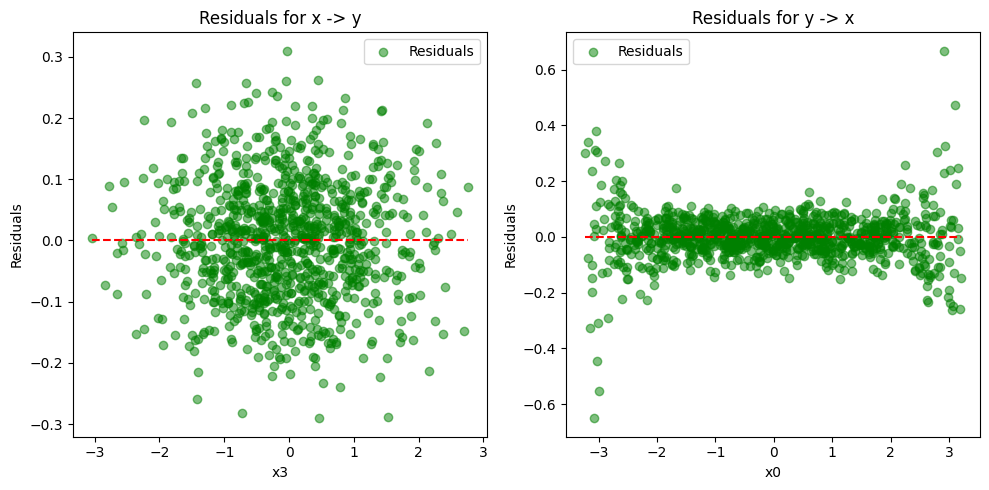

In [2]:
np.random.seed(0)
n_samples = 1000
x = np.random.normal(0, 1, n_samples)
noise = np.random.normal(0, .1, n_samples)
y = x + np.sin(x) + noise

# Model in the true causal direction
poly = PolynomialFeatures(degree=10, include_bias=False)
x_poly = poly.fit_transform(x.reshape(-1, 1))
model = LinearRegression().fit(x_poly, y)
y_pred = model.predict(x_poly)
y_residuals = y - y_pred

# Model in the anti-causal direction
poly_inverse = PolynomialFeatures(degree=10, include_bias=False)
y_poly = poly_inverse.fit_transform(y.reshape(-1, 1))
model_inverse = LinearRegression().fit(y_poly, x)
x_pred = model_inverse.predict(y_poly)
x_residuals = x - x_pred

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot residuals for the correct causal direction
ax[0].scatter(x, y_residuals, color='green', alpha=0.5, label='Residuals')
ax[0].hlines(0, xmin=min(x), xmax=max(x), colors='red', linestyles='--')
ax[0].set_xlabel('x3')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals for x -> y')
ax[0].legend()

# Plot residuals for the incorrect causal direction
ax[1].scatter(y, x_residuals, color='green', alpha=0.5, label='Residuals')
ax[1].hlines(0, xmin=min(y), xmax=max(y), colors='red', linestyles='--')
ax[1].set_xlabel('x0')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals for y -> x')
ax[1].legend()

plt.tight_layout()
plt.show()

### RESIT
We can use it with any regression model. Here, we will try it with a **random forest** and a **gaussian process regressor**.

In [3]:
import pandas as pd
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from lingam.utils import make_dot
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
# Linear structural equations with nongaussian noise
sample_size = 1000
x0 = np.random.uniform(low=0, high=1, size=sample_size)
x1 = -2*np.sin(2*x0) + np.random.beta(a=2, b=8, size=sample_size)
x2 = np.exp(-x0)*x1**2 + np.random.uniform(low=0, high=1, size=sample_size)
x3 = x1**3 - np.cos(x2) + np.random.normal(loc=0, scale=1, size=sample_size)
X = pd.DataFrame(np.array([x0, x1, x2, x3]).T, columns=['x0', 'x1', 'x2', 'x3'])

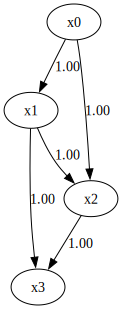

In [5]:
# Matrix of coefficients
m = np.array([[0.0, 0.0, 0.0, 0.0],
              [1.0, 0.0, 0.0, 0.0],
              [1.0, 1.0, 0.0, 0.0],
              [0.0, 1.0, 1.0, 0.0]])

# Saving graph
make_dot(m)

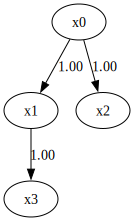

In [6]:
rf = RandomForestRegressor(random_state=0)
model = lingam.RESIT(regressor=rf)
model.fit(X)
model.adjacency_matrix_
make_dot(model.adjacency_matrix_)

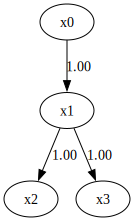

In [7]:
gpr = GaussianProcessRegressor(kernel=WhiteKernel() + RBF(), random_state=0, n_restarts_optimizer=1)
model = lingam.RESIT(regressor=gpr)
model.fit(X)
model.adjacency_matrix_
make_dot(model.adjacency_matrix_)